To install kernel run:

```
poetry run ipython kernel install --user --name=mpii
```

In [296]:
# imports
import os
from pathlib import Path
from scipy.io import loadmat
import scipy
import tqdm
import pickle
import logging
import time
import gc
%matplotlib
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from threading import Lock


Using matplotlib backend: nbAgg


In [46]:
# logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('pose_ordering')
logger.setLevel(logging.INFO)

In [33]:
# config

mpii_idx_to_jnt = {0: 'rankl', 1: 'rknee', 2: 'rhip', 5: 'lankl', 4: 'lknee', 3: 'lhip',
                   6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 11: 'relb', 10: 'rwri', 9: 'head',
                   12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'}

angles = [
    ['rwri', 'relb', 'rsho'],
    ['relb', 'rsho','thorax'],
    ['rsho','thorax', 'pelvis'],
    ['thorax','pelvis', 'rhip'],
    ['pelvis', 'rhip', 'rknee'],
    [ 'rhip', 'rknee', 'rankl'],
    ['rsho','thorax','upper_neck'],
    ['lwri', 'lelb', 'lsho'],
    ['lelb', 'lsho','thorax'],
    ['lsho','thorax','pelvis'],
    ['thorax','pelvis','lhip'],
    ['pelvis','lhip', 'lknee'],
    ['lhip', 'lknee', 'lankl'],
    ['lsho','thorax','upper_neck'],
    ['thorax','upper_neck', 'head'],
]

bones = [
    ['rankl', 'rknee', 'orange'],
    ['rknee', 'rhip', 'orange'],
    ['rhip','pelvis', 'orange'],
    ['lankl', 'lknee', 'yellow'],
    ['lknee', 'lhip', 'yellow'],
    ['lhip','pelvis', 'yellow'],

    ['rwri', 'relb', 'red'],
    ['relb','rsho', 'red'],
    ['rsho','thorax', 'red'],
    ['lwri', 'lelb', 'blue'],
    ['lelb','lsho', 'blue'],
    ['lsho','thorax', 'blue'],

    ['thorax','upper_neck', 'pink'],
    ['upper_neck','head', 'pink'],
    ['thorax','pelvis', 'green'],
]


filename = 'mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'


#matplotlib plot size
default_dpi = matplotlib.rcParamsDefault['figure.dpi']
matplotlib.rcParams['figure.dpi'] = default_dpi*2


In [18]:
%timeit
if os.path.exists(filename + '.p'):
    with open(filename + '.p', 'rb') as fp:
        gc.disable() # speeds up pickle.load by ~30%
        logger.debug('Loading pickled version')
        mat = pickle.load(fp)
        gc.enable()
else:
    logger.debug(f'Loading {filename}')
    mat = loadmat(filename)
    with open(filename + '.p', 'wb') as fp:
        pickle.dump(mat, fp)

DEBUG:pose_ordering:Loading pickled version


In [19]:

mpii = mat['RELEASE'][0,0]
num_images = mpii['annolist'][0].shape[0]

num_images

24987

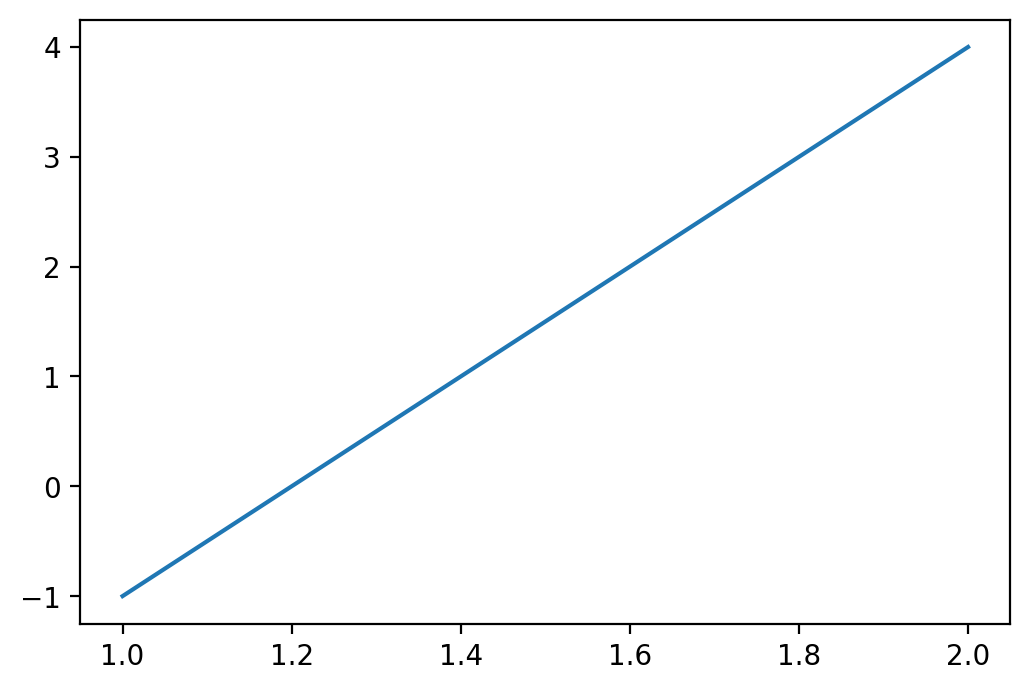

In [20]:
plt.plot([1,2], [-1,4]) 
  
# function to show the plot 
plt.show()

In [233]:
has_values = 0
visualise = False

vectors = []
vector_points = []

for idx in tqdm.tqdm(range(num_images)):
# for idx in range(num_images):
    # # is_training = mpii['img_train'][0,idx] # whether in train or test set
    # person_ids = mpii['single_person'][idx][0].flatten()

    # if not len(person_ids):
    #     # skip, because not enough persons
    #     continue
    
    annotations = mpii['annolist'][0,idx]
    anno_file = str(annotations[0]['name'][0][0][0])
    filename = '/home/ruben/Documents/Projecten/2020/Security Vision/tryouts/MPII Human Pose Dataset/images/'+anno_file
    logger.debug(filename)
    
    if visualise:
        image = Image.open(filename)

    if not len(annotations['annorect']):
        continue

    for annotation in annotations['annorect'][0]:
        # TODO : We might need to mirror the objects following a particular rule (see also Impett & Moretti)
        try:
            annotation_points = annotation['annopoints'][0,0]['point'][0]
        except Exception as e:
            # no points tagged for this one
            continue

        # logger.debug(points.shape[0])

        points = {}

        for point in annotation_points:
            x = float(point['x'].flatten()[0])
            y = float(point['y'].flatten()[0])
            id_ = point['id'][0][0]
            vis = point['is_visible'].flatten() if 'is_visible' in point else []
            joint = mpii_idx_to_jnt[id_]
            vis = int(vis[0]) if len(vis) else 0
            points[joint] = np.array([x,y, vis])

        
        if not all([joint in points for joint in mpii_idx_to_jnt.values()]):
            logger.debug(f"Not enough points: {points=}")
            break

#         if 'rhip' not in points or 'lhip' not in points or 'thorax' not in points:
#             logger.info(f"Not enough points: {points=}")
#             continue
        

        visible_joints = [joint for joint in mpii_idx_to_jnt.values() if joint in points]
    
        if visualise:
            plt.imshow(image)
            plt.plot(np.array([points[joint][0] for joint in visible_joints]), np.array([points[joint][1] for joint in visible_joints]), 'o')
        
        for bone in bones:
            if not all([bone[0] in points, bone[1] in points]):
                continue
            
            if visualise:
                plt.plot([points[bone[0]][0], points[bone[1]][0]], [points[bone[0]][1], points[bone[1]][1]], color=bone[2])

        
        annotation_vector = []

        for joints in angles:
            if not all([p in points for p in joints]):
                # check if all points to calculate joints are available 
                annotation_vector.append(None)  # CHOICE store null
                continue
            
            v1 = points[joints[0]] - points[joints[1]]
            v2 = points[joints[2]] - points[joints[1]]

            angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
            annotation_vector.append(angle*angle) # CHOICE squared angle?
            if visualise:
                plt.text(int(points[joints[1]][0]), int(points[joints[1]][1]), f"{angle:.4}")
 
        vector_points.append(points)
        vectors.append([annotation_vector, idx, len(vector_points)-1])
 
        
        has_values += 1
#         print(annotations)
#         break
    if visualise:
        plt.show() # show image
        if has_values > 2:
            break


  0%|          | 0/24987 [00:00<?, ?it/s]<ipython-input-233-6c8ee7259d48>:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  vis = point['is_visible'].flatten() if 'is_visible' in point else []
100%|██████████| 24987/24987 [00:19<00:00, 1282.47it/s]


In [144]:

print(len(vectors), vectors[1], vectors[-1])

17969 [[10.301455313174841, 0.8738769777401664, 7.932846045996372, 33.90556982877595, 4.788006833143501, 11.579460281021154, 6.330558392334423, 0.590823723139596, 5.670376354016367, 0.10566517419166079, 7.019067218895686, 0.9921823387865951, 7.12304248234401, 0.39129098417224434, 2.9091346049064142e-11], 4] [[2.199207456110774, 1.3408538112736343, 0.9907647738998692, 3.8666010567179896, 0.42119523559718064, 2.7174019285215865, 2.563494948040972, 1.3928467439375065, 2.901393929071837, 4.646466934360204, 27.37712157435963, 2.2728260851251068, 7.166142323804702, 22.581788879995116, 9.869588546386826], 24984]


In [118]:
from sklearn.preprocessing import StandardScaler


In [145]:
values = [v[0] for v in vectors]

In [265]:
x = StandardScaler().fit_transform(values) # normalizing the features


In [266]:
x.mean(), np.std(x)

(2.7179541485275698e-15, 1.0)

In [267]:
from sklearn.decomposition import PCA

In [268]:
# If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.: https://medium.com/@ansjin/dimensionality-reduction-using-pca-on-multivariate-timeseries-data-b5cc07238dc4
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(x)

In [269]:
pca.explained_variance_ratio_

array([0.1947121 , 0.14030244, 0.13287677, 0.09570534, 0.07844851,
       0.06633996, 0.06156485, 0.0560413 , 0.04303254, 0.03463799,
       0.02883156, 0.02305097, 0.01668491, 0.015404  , 0.01236676])

In [270]:
# pca.components_
# pca.get_precision()

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [271]:
def get_catname(act) -> str:
    return str(act['cat_name'][0][0]) if len(act['cat_name'][0]) else 'unknown'

In [294]:
# cats = [mpii['act'][v[1]]['cat_name'][0] for v in vectors]
cats= np.unique([get_catname(act) for act in mpii['act']]).tolist()
cats

array([[-2.35999232,  0.69057281],
       [-0.61853026,  1.07182264],
       [-1.18063219, -0.16670125],
       ...,
       [ 1.95397646, -2.77908482],
       [ 1.47253967, -0.71394096],
       [ 1.82195482, -2.03658075]])

<IPython.core.display.Javascript object>


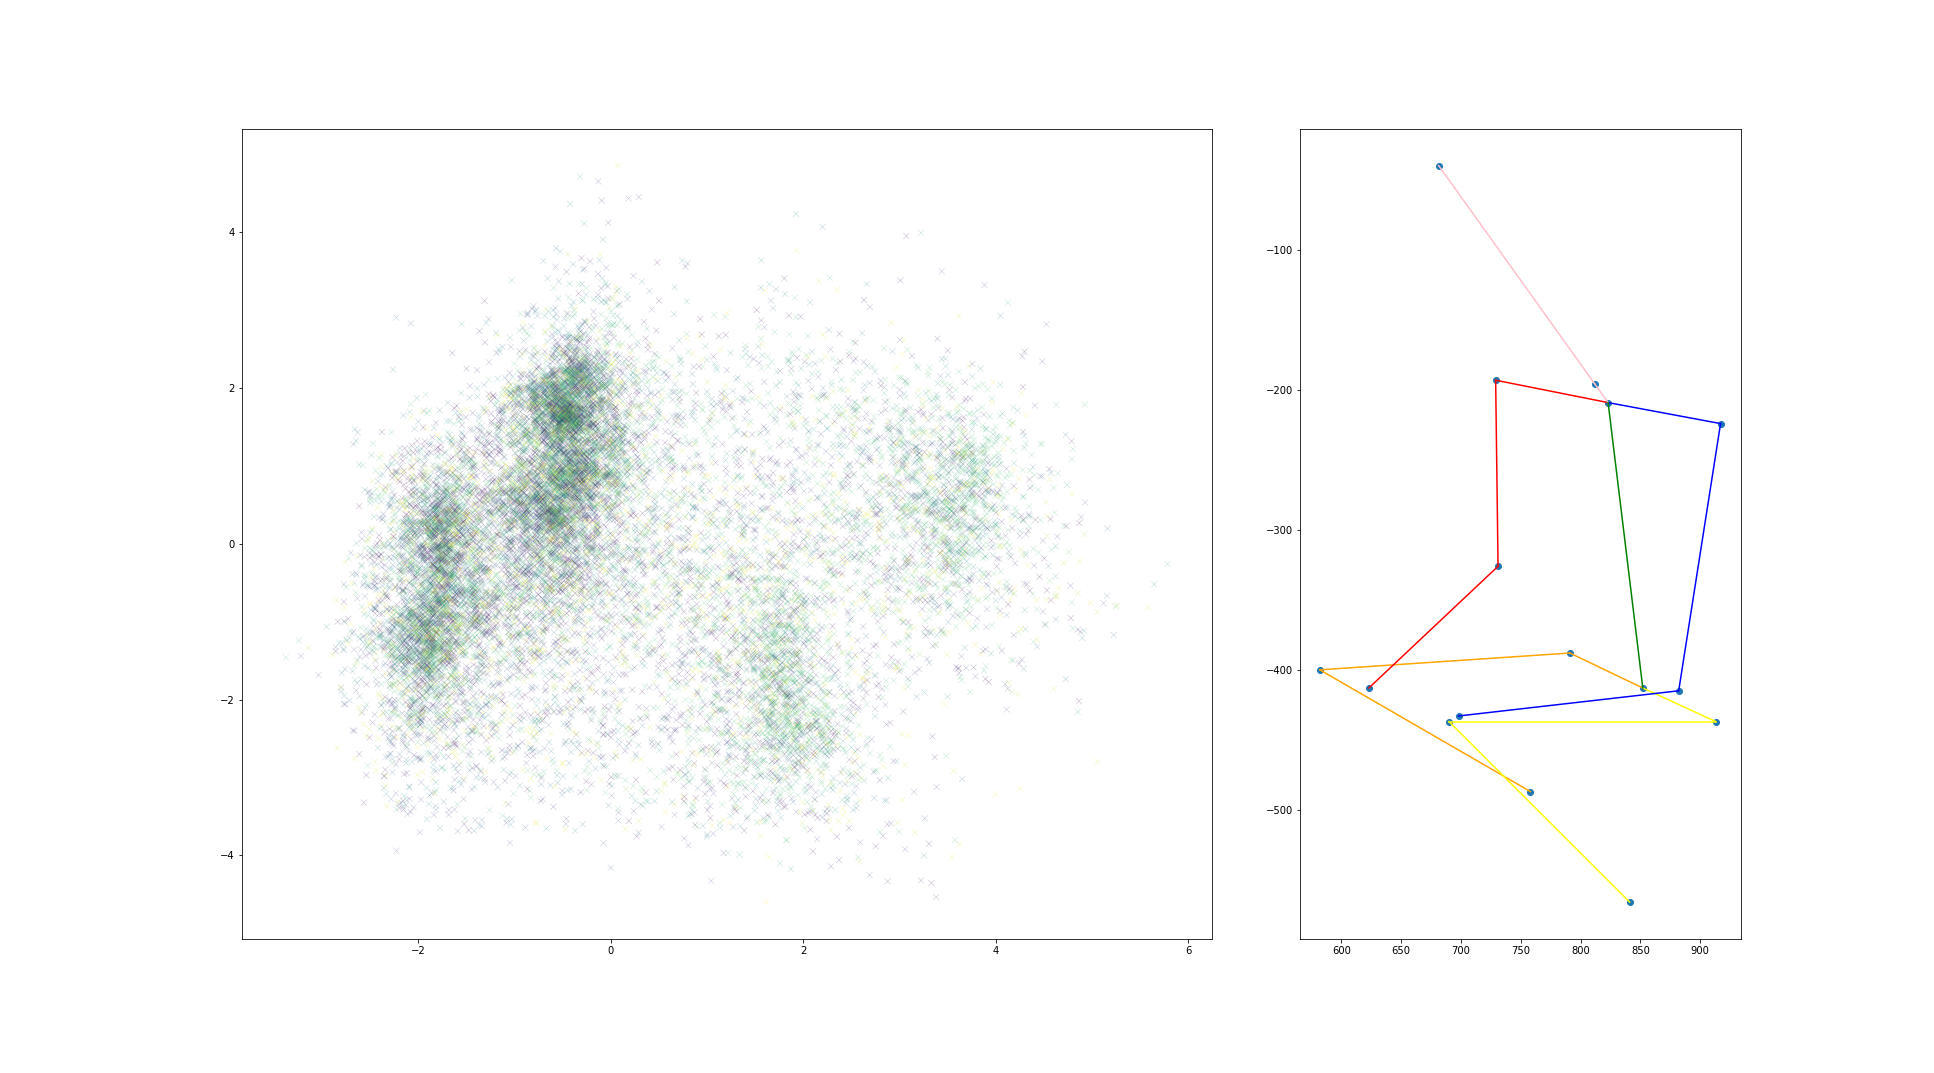

In [326]:
# t = [mpii['act'][v[1]]['act_id'][0][0] for v in vectors]
t = [cats.index(get_catname(mpii['act'][v[1]])) for v in vectors]

fig = plt.figure()
ax = fig.add_subplot(1,3,(1,2))
ax_figures = fig.add_subplot(1,3,3)

kdtree= scipy.spatial.KDTree(principalComponents[:,[0,1]]) # CHOICE only consider first two dimensions...


def show_closest(event):
    closest = kdtree.query([event.xdata, event.ydata], workers=-1)
    ax_figures.clear()
        
    distance, vector_idx = closest
    annotation_idx = vectors[vector_idx][1]
    points_idx = vectors[vector_idx][2]
    anno_points = np.array(list(vector_points[points_idx].values()))
    ax_figures.plot(anno_points[:,0], anno_points[:,1]*-1, 'o')
    
    for bone in bones:
        if not all([bone[0] in vector_points[points_idx], bone[1] in vector_points[points_idx]]):
            continue
        ax_figures.plot([vector_points[points_idx][bone[0]][0], vector_points[points_idx][bone[1]][0]], [-vector_points[points_idx][bone[0]][1], -vector_points[points_idx][bone[1]][1]], color=bone[2])

#     ax_figures.plot(np.random.rand(10))


def onclick(event):
    show_closest(event)

processing = Lock()
def onmove(event):
    if not event.xdata or not event.ydata:
        return
    
    if processing.acquire(blocking=False):
        try:
            show_closest(event)
        finally:
            processing.release()
    

cid = fig.canvas.mpl_connect('motion_notify_event', onmove)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

ax.scatter(principalComponents[:,0], principalComponents[:,1], c=t, cmap="viridis",alpha=.3, marker='x', linewidth=.5)



In [308]:
closest[1], closest_old[1]

(17486, 17486)

In [321]:
import random

[[18.323586368221292,
  20.398791852918905,
  4.987799082127334,
  0.40959807507019436,
  12.429795844069234,
  16.96079790482587,
  5.768238809731072,
  3.234665667673784,
  2.764261279400277,
  28.889880637691366,
  6.257973328552808,
  0.954098950748553,
  11.425504813879593,
  30.728268671099034,
  7.83325651958665e-12],
 579,
 379]

In [ ]:
nr = random.randint(0, len(vectors)-1)

imgidx = vectors[nr][1]
principalComponents[nr]
# vectors[6]
annotations = mpii['annolist'][0,imgidx]
anno_file = str(annotations[0]['name'][0][0][0])
filename = '/home/ruben/Documents/Projecten/2020/Security Vision/tryouts/MPII Human Pose Dataset/images/'+anno_file
print(mpii['act'][imgidx]['cat_name'],
mpii['act'][imgidx]['act_name'], mpii['act'][imgidx]['act_id'],
int(mpii['act'][imgidx]['act_id'][0][0])
     )
Image.open(filename)